In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
==============================spm-mcmc-estw


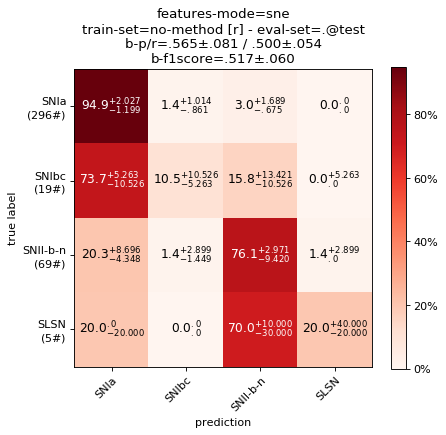

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0864
[2#] SPM_gamma_r=.0685
[3#] LinearTrend_g=.0664
[4#] LinearTrend_r=.0602
[5#] SPM_beta_r=.0573
[6#] SPM_tau_fall_r=.0569
[7#] SPM_t0_r=.0568
[8#] SPM_tau_rise_r=.0479
[9#] SPM_tau_fall_g=.0456
[10#] SPM_gamma_g=.0452


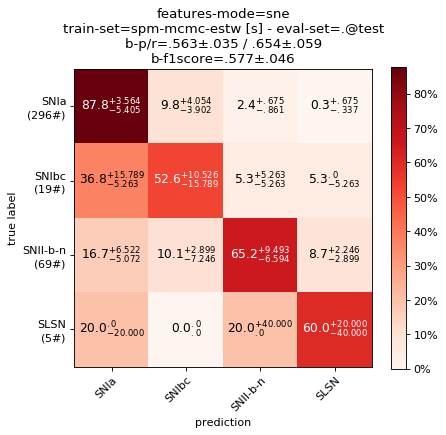

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0935
[2#] SPM_t0_r=.0696
[3#] SPM_tau_rise_r=.0622
[4#] SPM_gamma_r=.0619
[5#] LinearTrend_g=.0598
[6#] LinearTrend_r=.0538
[7#] SPM_beta_r=.0516
[8#] SPM_tau_fall_r=.0512
[9#] SPM_tau_fall_g=.0410
[10#] SPM_gamma_g=.0406


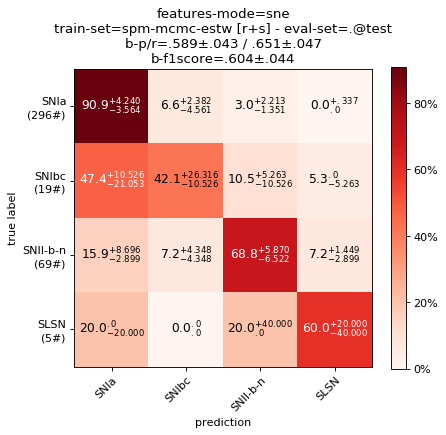

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.1001
[2#] SPM_gamma_r=.0638
[3#] LinearTrend_g=.0630
[4#] SPM_tau_rise_r=.0557
[5#] SPM_t0_r=.0554
[6#] SPM_tau_fall_r=.0549
[7#] LinearTrend_r=.0530
[8#] SPM_beta_r=.0518
[9#] SPM_tau_fall_g=.0451
[10#] SPM_gamma_g=.0410


In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import search_for_filedirs, gather_files_by_kfold
from flamingchoripan.cuteplots.cm_plots import plot_custom_confusion_matrix
import matplotlib.pyplot as plt
from flamingchoripan.datascience.xerror import XError
from IPython.display import display

mode = 'sne' # sne all
methods = [
    'linear-fstw',
    'bspline-fstw',
    'spm-mle-fstw',
    'spm-mcmc-fstw',
    'spm-mle-estw',
    'spm-mcmc-estw',
]
methods = ['spm-mcmc-estw']
eval_lcset_name = 'test'
kf = '.'

for method in methods:
    print('='*30+method)
    #for train_config in ['r', 's']:
    for train_config in ['r', 's', 'r+s']:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        class_names = files[0]()['lcset_info']['class_names']
        cms = np.concatenate([f()['cm'][None] for f in files], axis=0)
        bf1score_xe = XError([f()['metrics_dict']['b-f1score'] for f in files])
        bprecision_xe = XError([f()['metrics_dict']['b-precision'] for f in files])
        brecall_xe = XError([f()['metrics_dict']['b-recall'] for f in files])

        ### plot cm
        _title = 'no-method [r]' if train_config=='r' else f'{method} [{train_config}]'
        title = ''
        title += f'features-mode={mode}'+'\n'
        title += f'train-set={_title} - eval-set={kf}@{eval_lcset_name}'+'\n'
        title += f'b-p/r={bprecision_xe} / {brecall_xe}'+'\n'
        title += f'b-f1score={bf1score_xe}'+'\n'
        cm_kwargs = {
            'title':title[:-1],
            'figsize':(6,5),
            'new_order_classes':['SNIa', 'SNIbc', 'SNII-b-n', 'SLSN'],
        }
        fig, ax, cm_norm = plot_custom_confusion_matrix(cms, class_names, **cm_kwargs)
        #accu = XError(np.diagonal(cm_norm*100, axis1=1, axis2=2).flatten().tolist())
        #title += f'b-accu={accu}'+'\n'
        #ax.set_title(title[:-1])
        #print(files[0]()['features'])
        plt.show()
        #assert 0
        print(class_names)
        print(files[0]()['rank'])
        df = files[0]()['wrongs_df']
        #display(df[df['_y']==0])
        #display(df[df['_y']==2])

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

dmetrics = {
    f'b-precision':{'k':1, 'mn':None},
    f'b-recall':{'k':1, 'mn':None},
    f'b-f1score':{'k':1, 'mn':None},
    #f'b-rocauc':{'k':1, 'mn':'b-ROCAUC'},
    #f'b-prauc':{'k':1, 'mn':'b-PRAUC'},
    }
info_df = DFBuilder()
for metric in dmetrics.keys():
    for train_config in ['r', 's', 'r+s']:
    #for train_config in ['r', 's']:
        d = {}
        for method in methods:
            rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
            files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
            metric_xe = XError([f()['metrics_dict'][metric]*dmetrics[metric]['k'] for f in files])
            d[method] = metric_xe
            #print(len(metric_xe))
        
        if train_config=='r': # mean across methods in real case
            new_metric_xe = sum([d[k] for k in d.keys()])
            d = {k:new_metric_xe for k in d.keys()}
            
        mn = dmetrics[metric]['mn']
        info_df.append(f'metric={metric if mn is None else mn} [{train_config}]', d)

caption = ''
if kf=='.':
    caption += f'Synthetic generation methods performance in {eval_lcset_name}-set using only real samples [r], only synthetic samples [s], and the same proportion of real and synthetic samples [r+s]. '
    caption += f'Using only SNe astrophysical features ' if mode=='sne' else f'Using all SNe astrophysical features '
    caption += f'($m\pm\\sigma$ from 5-fold cross-validation)'
else:
    caption += f'eval-set={kf}@{eval_lcset_name}'
latex_kwargs = {
    'caption':caption,
    'label':'?',
    'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
    'hline_k':2,
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)
print('% \multicolumn{3}{c|}{}')
info_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{Synthetic generation methods performance in test-set using only real samples [r], only synthetic samples [s], and the same proportion of real and synthetic samples [r+s]. Using only SNe astrophysical features ($m\pm\sigma$ from 5-fold cross-validation)}
\label{?}\vspace{.1cm}
\begin{tabular}{l|cccc|cc}
\hline
metric & linear-fstw & bspline-fstw & spm-mle-fstw & spm-mcmc-fstw & spm-mle-estw & spm-mcmc-estw \srule\\\hline\hline
b-precision [r] & .561$\pm$.078 & .561$\pm$.078 & .561$\pm$.078 & .561$\pm$.078 & .561$\pm$.078 & .561$\pm$.078  \srule\\
b-precision [s] & .563$\pm$.043 & .518$\pm$.037 & .557$\pm$.034 & .563$\pm$.034 & .556$\pm$.038 & .563$\pm$.035  \srule\\
b-precision [r+s] & .576$\pm$.048 & .573$\pm$.033 & .

,linear-fstw,bspline-fstw,spm-mle-fstw,spm-mcmc-fstw,spm-mle-estw,spm-mcmc-estw
metric=b-precision [r],.561±.078,.561±.078,.561±.078,.561±.078,.561±.078,.561±.078
metric=b-precision [s],.563±.043,.518±.037,.557±.034,.563±.034,.556±.038,.563±.035
metric=b-precision [r+s],.576±.048,.573±.033,.583±.045,.590±.045,.588±.045,.589±.043
metric=b-recall [r],.498±.053,.498±.053,.498±.053,.498±.053,.498±.053,.498±.053
metric=b-recall [s],.649±.053,.569±.059,.649±.051,.657±.050,.644±.055,.654±.059
metric=b-recall [r+s],.642±.056,.628±.045,.656±.055,.655±.052,.652±.052,.651±.047
metric=b-f1score [r],.513±.058,.513±.058,.513±.058,.513±.058,.513±.058,.513±.058
metric=b-f1score [s],.574±.054,.522±.043,.568±.043,.579±.043,.567±.049,.577±.046
metric=b-f1score [r+s],.589±.053,.585±.038,.600±.050,.606±.048,.604±.050,.604±.044


In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

info_df = DFBuilder()
train_config = 'r+s' # r s r+s
rank_n = 10
for k in range(0, rank_n):
    d = {}
    for method in methods:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        rank = files[0]()['rank'] # just show one
        feature_name, feature_p,_ = rank[k]
        feature_name = feature_name.replace('_', '-')
        d[f'{method} [{train_config}]'] = f'{feature_name} ({feature_p*100:.3f}%)'

    info_df.append(f'rank={k+1}', d)

caption = ''
caption += f'Ranking sample of astrophysical features for {eval_lcset_name}-set. '
caption += f'Using only SNe astrophysical features.' if mode=='sne' else f'Using all SNe astrophysical features.'
latex_kwargs = {
    'caption':caption,
    'label':'?',
    'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)
info_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{Ranking sample of astrophysical features for test-set. Using only SNe astrophysical features.}
\label{?}\vspace{.1cm}
\begin{tabular}{l|cccc|cc}
\hline
rank & linear-fstw [r+s] & bspline-fstw [r+s] & spm-mle-fstw [r+s] & spm-mcmc-fstw [r+s] & spm-mle-estw [r+s] & spm-mcmc-estw [r+s] \srule\\\hline\hline
1 & SPM-t0-g (9.162\%) & LinearTrend-g (8.650\%) & SPM-t0-g (9.901\%) & SPM-t0-g (10.039\%) & SPM-t0-g (9.770\%) & SPM-t0-g (10.011\%)  \srule\\
2 & LinearTrend-g (7.031\%) & SPM-t0-g (8.032\%) & LinearTrend-g (7.356\%) & LinearTrend-g (7.337\%) & LinearTrend-g (6.534\%) & SPM-gamma-r (6.390\%)  \srule\\
3 & SPM-t0-r (6.281\%) & LinearTrend-r (6.596\%) & SPM-gamma-r (6.344\%) & SPM-t0-r (6.274\%) & SPM-gamma-r (6.326\%

,linear-fstw [r+s],bspline-fstw [r+s],spm-mle-fstw [r+s],spm-mcmc-fstw [r+s],spm-mle-estw [r+s],spm-mcmc-estw [r+s]
rank=1,SPM-t0-g (9.162%),LinearTrend-g (8.650%),SPM-t0-g (9.901%),SPM-t0-g (10.039%),SPM-t0-g (9.770%),SPM-t0-g (10.011%)
rank=2,LinearTrend-g (7.031%),SPM-t0-g (8.032%),LinearTrend-g (7.356%),LinearTrend-g (7.337%),LinearTrend-g (6.534%),SPM-gamma-r (6.390%)
rank=3,SPM-t0-r (6.281%),LinearTrend-r (6.596%),SPM-gamma-r (6.344%),SPM-t0-r (6.274%),SPM-gamma-r (6.326%),LinearTrend-g (6.301%)
rank=4,LinearTrend-r (5.892%),SPM-t0-r (6.266%),SPM-t0-r (6.079%),SPM-gamma-r (5.938%),SPM-t0-r (5.969%),SPM-tau-rise-r (5.573%)
rank=5,SPM-tau-rise-r (5.799%),SPM-gamma-r (5.446%),SPM-beta-r (5.482%),SPM-tau-rise-r (5.725%),LinearTrend-r (5.735%),SPM-t0-r (5.542%)
rank=6,SPM-beta-r (5.755%),SPM-tau-rise-r (5.206%),SPM-tau-rise-r (5.300%),LinearTrend-r (5.647%),SPM-beta-r (5.402%),SPM-tau-fall-r (5.495%)
rank=7,SPM-tau-fall-r (5.530%),SPM-gamma-g (4.779%),SPM-tau-fall-r (5.276%),SPM-beta-r (5.314%),SPM-tau-fall-r (5.228%),LinearTrend-r (5.301%)
rank=8,SPM-gamma-r (5.513%),SPM-tau-fall-g (4.541%),LinearTrend-r (5.211%),SPM-tau-fall-r (5.145%),SPM-tau-rise-r (5.009%),SPM-beta-r (5.181%)
rank=9,SPM-tau-fall-g (4.548%),SPM-beta-r (4.160%),SPM-tau-fall-g (4.468%),SPM-tau-fall-g (4.713%),SPM-tau-fall-g (4.398%),SPM-tau-fall-g (4.520%)
rank=10,SPM-gamma-g (3.874%),MHPS-low-r (3.565%),SPM-gamma-g (4.103%),SPM-gamma-g (3.743%),SPM-gamma-g (3.891%),SPM-gamma-g (4.108%)
